In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

## Create vector field with some eddies

$$
G(x,y) = \left(\frac{-y}{1 + x^2 + y^2} , \frac{x}{1 + x^2 + y^2}\right)
$$
$$
V(x,y) = G(x-6,y) + G(x+6,y) - G(x,y-6) + G(x,y+6)
$$

<IPython.core.display.Javascript object>


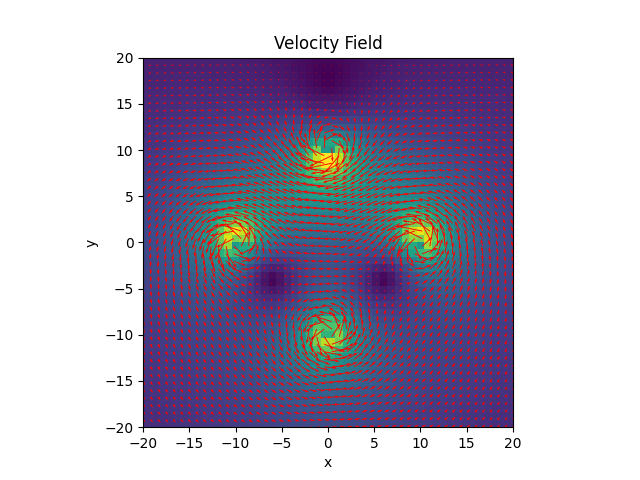

Text(0.5, 1.0, 'Velocity Field')

In [163]:
xlim = (-20, 20)
ylim = (-20, 20)

x = np.linspace(*xlim, num=50)
y = np.linspace(*ylim, num=50)

xx, yy = np.meshgrid(x, y, indexing='xy')

def vort_x(x, y):
    return (-y)/(1 + x**2 + y**2)

def vort_y(x, y):
    return (x)/(1 + x**2 + y**2)

V_x = vort_x(xx - 10,yy) + vort_x(xx + 10,yy) - vort_x(xx,yy-10) + vort_x(xx,yy+10)
V_y = vort_y(xx - 10,yy) + vort_y(xx + 10,yy) - vort_y(xx,yy-10) + vort_y(xx,yy+10)
vel_magnitude = np.hypot(V_x, V_y)

plt.figure()
plt.quiver(xx, yy ,V_x, V_y, color='r', scale=9)
plt.imshow(vel_magnitude, origin='lower', extent=[*xlim, *ylim])
plt.xlabel("x")
plt.ylabel("y")
plt.title("Velocity Field")

## Compute curl

Velocity Field $\mathbf{v}(x,y) = (v_x(x,y), v_y(x,y))$

$$
\nabla \times \mathbf{v} = \frac{\partial v_y}{\partial x} - \frac{\partial v_x}{\partial y}
$$

<IPython.core.display.Javascript object>


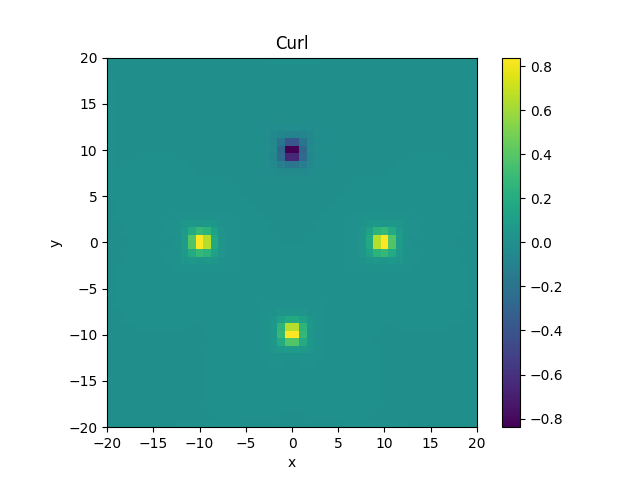

Text(0, 0.5, 'y')

In [158]:
curl = np.gradient(V_y, axis=1) - np.gradient(V_x, axis=0)
plt.figure()
plt.imshow(curl, extent=[*xlim, *ylim], origin='lower')
plt.colorbar()
plt.title("Curl")
plt.xlabel("x")
plt.ylabel("y")

## Okubo–Weiss parameter
Okubo, A., 1970: Horizontal dispersion of floatable particles in the vicinity of velocity singularities such as convergences. Deep-Sea Res., 17, 445–454

A nice reference for how to actually calculate the thing: https://miolaseyne.ifremer.fr/sciences/ELISA/isern_AEs_Okubo.pdf

$$
W = s_n^2 + s_s^2 + \omega^2
$$

where $s_n$, $s_s$ and $\omega$ are the normal and the shear
components of strain and the curl of the flow defined respectively by

$$
s_n = \frac{\partial v_x}{\partial x} - \frac{\partial v_y}{\partial y}
$$

$$
s_s = \frac{\partial v_x}{\partial x} + \frac{\partial v_y}{\partial y}
$$

$$
\omega = \frac{\partial v_y}{\partial x} - \frac{\partial v_x}{\partial y}
$$

<IPython.core.display.Javascript object>


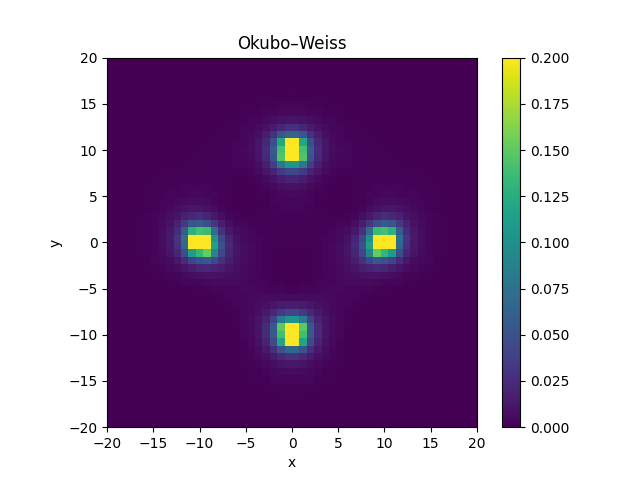

Text(0, 0.5, 'y')

In [164]:
strain_normal = np.gradient(V_x, axis=1) - np.gradient(V_y, axis=0)
strain_shear = np.gradient(V_y, axis=1) + np.gradient(V_x, axis=0)

W = strain_normal**2 + strain_shear**2 + curl**2

plt.figure()
plt.imshow(W, extent=[*xlim, *ylim], origin='lower')
plt.clim(0,0.2)
plt.colorbar()
plt.title("Okubo–Weiss")
plt.xlabel("x")
plt.ylabel("y")

## Example thresholding using Okubo-Weiss

<IPython.core.display.Javascript object>


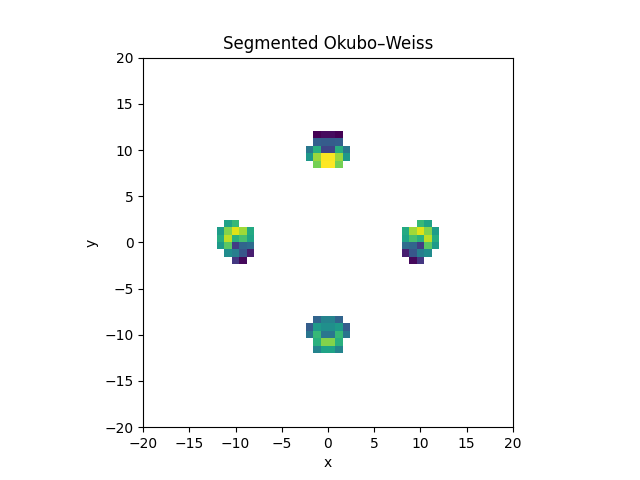

Text(0, 0.5, 'y')

In [165]:
threshold = 0.05
W_eddies = np.ma.masked_where(W < threshold, np.hypot(V_x, V_y))
plt.figure()
plt.imshow(W_eddies, origin='lower', extent=[*xlim, *ylim])
plt.title("Segmented Okubo–Weiss")
plt.xlabel("x")
plt.ylabel("y")

## Calculate Centroid of the thresholded areas

<IPython.core.display.Javascript object>


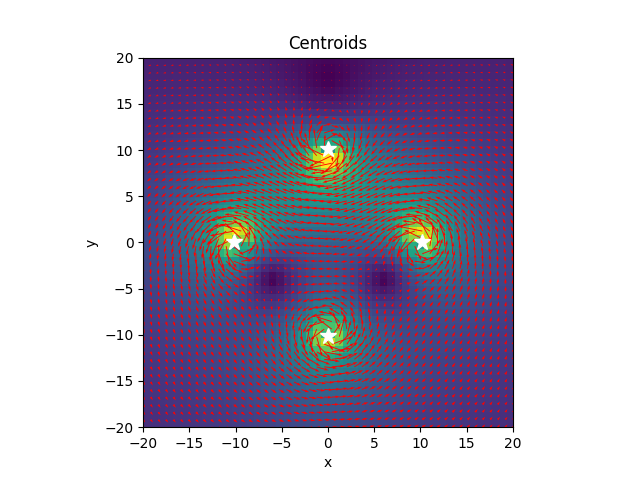

Text(0, 0.5, 'y')

In [166]:
from scipy import ndimage

labeled_array, num_features = ndimage.label(W > threshold)

centroids = []

for i in range(1, num_features + 1):
    mask = labeled_array == i
    masked_x = xx[mask]
    x_bar = masked_x.sum() / masked_x.size
    masked_y = yy[mask]
    y_bar = masked_y.sum() / masked_y.size
    centroids.append((x_bar, y_bar))

centroids = np.asarray(centroids)

plt.figure()
plt.quiver(xx, yy ,V_x, V_y, color='r', scale=9)
plt.imshow(vel_magnitude, origin='lower', extent=[*xlim, *ylim])
plt.plot(centroids[:,0], centroids[:,1], 'w*', markersize=12)
plt.title("Centroids")
plt.xlabel("x")
plt.ylabel("y")

## Integrating a partical

<IPython.core.display.Javascript object>


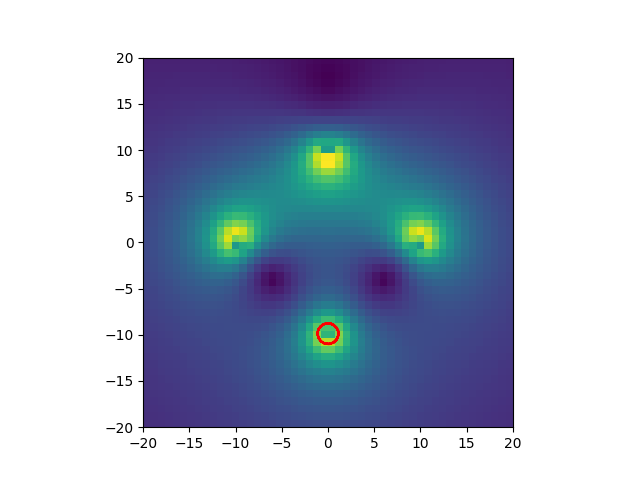

In [173]:
from scipy.interpolate import RegularGridInterpolator
from scipy.integrate import solve_ivp

# first build an interpolator over the x and y velocity
m,n = V_x.shape
x = np.linspace(*xlim, n)
y = np.linspace(*ylim, m)
method = "linear"

interp_vel_x = RegularGridInterpolator((x, y), V_x.T, method=method)
interp_vel_y = RegularGridInterpolator((x, y), V_y.T, method=method)

def rhs(t, x):
    try:
        return [interp_vel_x(x).squeeze(), interp_vel_y(x).squeeze()]
    except ValueError:
        # particle has left domain
        return [0, 0]

sol = solve_ivp(rhs, (0, 100), [0, -11], max_step=1)
plt.figure()
plt.imshow(vel_magnitude, origin='lower', extent=[*xlim, *ylim])
plt.plot(sol.y[0], sol.y[1], 'r-')